<a href="https://colab.research.google.com/github/mozhgans/Transformers-Duke/blob/main/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

In [3]:
from torchvision import datasets, transforms

mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
print("Number of MNIST training examples: {}".format(len(mnist_train)))


Number of MNIST training examples: 60000


In [5]:
print("Number of MNIST test examples: {}".format(len(mnist_test)))

Number of MNIST test examples: 10000


Default image shape: torch.Size([1, 28, 28])
Reshaped image shape: torch.Size([28, 28])
The label for this image: 1


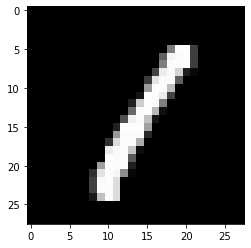

In [6]:
# Pick out the 4th (0-indexed) example from the training set
image, label = mnist_train[3]

# Plot the image
print("Default image shape: {}".format(image.shape))
image = image.reshape([28,28])
print("Reshaped image shape: {}".format(image.shape))
plt.imshow(image, cmap="gray")

# Print the label
print("The label for this image: {}".format(label))

In [8]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

In [9]:
data_train_iter = iter(train_loader)
images, labels = data_train_iter.next()

print("Shape of the minibatch of images: {}".format(images.shape))
print("Shape of the minibatch of labels: {}".format(labels.shape))

Shape of the minibatch of images: torch.Size([100, 1, 28, 28])
Shape of the minibatch of labels: torch.Size([100])


In [10]:
x = images.view(-1, 28*28)
print("The shape of input x: {}".format(x.shape))

The shape of input x: torch.Size([100, 784])


In [11]:
# Randomly initialize weights W
W = torch.randn(784, 10)/np.sqrt(784)
W.requires_grad_()

# Initialize bias b as 0s
b = torch.zeros(10, requires_grad=True)

In [12]:
W

tensor([[-0.0119,  0.0128, -0.0491,  ...,  0.0168,  0.0385, -0.0176],
        [ 0.0140, -0.0684,  0.0106,  ..., -0.0346, -0.0021, -0.0032],
        [ 0.0257,  0.0169,  0.0310,  ..., -0.0033, -0.0395,  0.0074],
        ...,
        [-0.0077,  0.0463, -0.0125,  ..., -0.0185, -0.0008,  0.0079],
        [ 0.0328, -0.0758,  0.0471,  ..., -0.0073, -0.0284,  0.0090],
        [-0.0661,  0.0124, -0.0299,  ...,  0.0363, -0.0266, -0.0066]],
       requires_grad=True)

In [13]:
b

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

As both W and b are parameters we wish to learn, we set requires_grad to True. This tells PyTorch's autograd to track the gradients for these two variables, and all the variables depending on W and b.

With these model parameters, we compute  𝑦 :

In [14]:
# Linear transformation with W and b
y = torch.matmul(x, W) + b

In [15]:
print(y[0,:])

tensor([-0.3230,  0.2273,  0.3268,  0.1835,  0.0026,  0.2382, -0.3825,  0.4004,
         0.2352, -0.0829], grad_fn=<SliceBackward>)


We can interpret these values (aka logits)  𝑦  as probabilities if we normalize them to be positive and add up to 1. In logistic regression, we do this with a softmax.𝑝(𝑦𝑖)=softmax(𝑦𝑖)=exp(𝑦𝑖)∑𝑗exp(𝑦𝑗)
We can compute the softmax ourselves using the above formula if we'd like, but PyTorch already has the softmax function in `torch.nn.functional`:

In [16]:
# Option 1: Softmax to probabilities from equation
py_eq = torch.exp(y) / torch.sum(torch.exp(y), dim=1, keepdim=True)
print("py[0] from equation: {}".format(py_eq[0]))

# Option 2: Softmax to probabilities with torch.nn.functional
import torch.nn.functional as F
py = F.softmax(y, dim=1)
print("py[0] with torch.nn.functional.softmax: {}".format(py[0]))

py[0] from equation: tensor([0.0646, 0.1121, 0.1238, 0.1073, 0.0895, 0.1133, 0.0609, 0.1333, 0.1130,
        0.0822], grad_fn=<SelectBackward>)
py[0] with torch.nn.functional.softmax: tensor([0.0646, 0.1121, 0.1238, 0.1073, 0.0895, 0.1133, 0.0609, 0.1333, 0.1130,
        0.0822], grad_fn=<SelectBackward>)


We've now defined the forward pass of our model: given an input image, the graph returns the probabilities the model thinks the input is each of the 10 classes. Are we done?

The cross-entropy loss
This tutorial isn't done yet, so you can probably guess that the answer is not quite. We don't know the values of  𝑊  and  𝑏  yet! Remember how we initialized them randomly? Before we adjust any of the weights, we need a way to measure how the model is doing. Specifically, we're going to measure how badly the model is doing. We do this with a loss function, which takes the model's prediction and returns a single number (i.e. a scalar) summarizing model performance. This loss will inform how we adjust the parameters of the model.

The loss we commonly use in classification is cross-entropy, a concept from information theory. Explaining exactly what the cross-entropy represents goes slightly beyond the scope of this course, but you can think of it as a way of quantifying how far apart one distribution  𝑦′  is from another  𝑦 .

𝐻𝑦′(𝑦)=−∑𝑖𝑦′𝑖log(𝑦𝑖)
 
In our case,  𝑦  is the set of probabilities predicted by the model ( 𝑝𝑦  above);  𝑦′  is the target distribution. What is the target distribution? It's the true label, which is what we wanted the model to predict.

Cross-entropy not only captures how correct (max probability corresponds to the right answer) the model's answers are, it also accounts for how confident (high confidence in correct answers) they are. This encourages the model to produce very high probabilities for correct answers while driving down the probabilities for the wrong answers, instead of merely being satisfied with it being the argmax.

We focus here on supervised learning, a setting in which we have the labels. Our DataLoader automatically includes the corresponding labels for each of our inputs. Here are the labels from the first time we retrieved a minibatch:

In [17]:
print(labels.shape)

torch.Size([100])


Like the softmax operation, we can implement the cross-entropy directly from the equation, using the softmax output. However, as with the softmax, torch.nn.functional already has the cross-entropy loss implemented as well.

In [22]:
# Cross-entropy loss from equation
cross_entropy_eq = torch.mean(-torch.log(py_eq)[range(labels.shape[0]),labels])
print("cross entropy from equation: {}".format(cross_entropy_eq))

# Option 2: cross-entropy loss with torch.nn.functional
cross_entropy = F.cross_entropy(y, labels)
print("cross entropy with torch.nn.functional.cross_entropy: {}".format(cross_entropy))

cross entropy from equation: 2.308309555053711
cross entropy with torch.nn.functional.cross_entropy: 2.308309555053711


The backwards pass
Now that we have the loss as a way of quantifying how badly the model is doing, we can improve our model by changing the parameters in a way that minimizes the loss. For neural networks, the common way of doing this is with backpropagation: we take the gradient of the loss with respect to  𝑊  and  𝑏  and take a step in the direction that reduces our loss.

If we were not using a deep learning framework like PyTorch, we would have to go through and derive all the gradients ourselves by hand, then code them into our program. We certainly still could. However, with modern auto-differentiation libraries, it's much faster and easier to let the computer do it.

First, we need to create an optimizer. There are many choices, but since logistic regression is fairly simple, we'll use standard stochastic gradient descent (SGD), which makes the following update.
where  𝜃  is a parameter,  𝛼  is our learning rate (step size), and  ∇𝜃  is the gradient of our loss with respect to  𝜃 .

In [21]:
# Optimizer
optimizer = torch.optim.SGD([W,b], lr=0.1)

When we created our parameters  𝑊  and  𝑏 , we indicated that they require gradients. To compute the gradients for  𝑊  and  𝑏 , we call the backward() function on the cross-entropy loss.

In [23]:
cross_entropy.backward()

Each of the variables that required gradients have now accumulated gradients. We can see these for example on b:

In [24]:
b.grad

tensor([-0.0255, -0.0798,  0.0504, -0.0126, -0.0465,  0.0673, -0.0225,  0.0178,
         0.0395,  0.0118])

To apply the gradients, we could manually update  𝑊  and  𝑏  using the update rule  𝜃𝑡+1=𝜃𝑡−𝛼∇𝜃 , but since we have an optimizer, we can tell it to perform the update step for us:

In [25]:
optimizer.step()

We set our learning rate to 0.1, so b has been updated by -0.1*b.grad:

In [26]:
b

tensor([ 0.0025,  0.0080, -0.0050,  0.0013,  0.0047, -0.0067,  0.0023, -0.0018,
        -0.0040, -0.0012], requires_grad=True)

We've now successfully trained on a minibatch! However, one minibatch probably isn't enough. At this point, we've trained the model on 100 examples out of the 60000 in the training set. We're going to need to repeat this process, for more of the data.

One more thing to keep in mind though: gradients calculated by backward() don't override the old values; instead, they accumulate. Therefore, you'll want to clear the gradient buffers before you compute gradients for the next minibatch.

In [27]:
print("b.grad before zero_grad(): {}".format(b.grad))
optimizer.zero_grad()
print("b.grad after zero_grad(): {}".format(b.grad))

b.grad before zero_grad(): tensor([-0.0255, -0.0798,  0.0504, -0.0126, -0.0465,  0.0673, -0.0225,  0.0178,
         0.0395,  0.0118])
b.grad after zero_grad(): tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Model Training
To train the model, we just need repeat what we just did for more minibatches from the training set. As a recap, the steps were:

-Draw a minibatch

-Zero the gradients in the buffers for W and b

-Perform the forward pass (compute prediction, calculate loss)

-Perform the backward pass (compute gradients, perform SGD step)

Going through the entire dataset once is referred to as an epoch. In many cases, we train neural networks for multiple epochs, but here, a single epoch is enough. We also wrap the train_loader with tqdm. This isn't neccessary, but it adds a handy progress bar so we can track our training progress.

In [29]:
# Iterate through train set minibatchs 
for images, labels in tqdm(train_loader):
    # Zero out the gradients
    optimizer.zero_grad()
    
    # Forward pass
    x = images.view(-1, 28*28)
    y = torch.matmul(x, W) + b
    cross_entropy = F.cross_entropy(y, labels)
    # Backward pass
    cross_entropy.backward()
    optimizer.step()

Testing
Now let's see how we did! For every image in our test set, we run the data through the model, and take the digit in which we have the highest confidence as our answer. We then compute an accuracy by seeing how many we got correct. We're going to wrap evaluation with torch.no_grad(), as we're not interested in computing gradients during evaluation. By turning off the autograd engine, we can speed up evaluation.

In [30]:
correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images.view(-1, 28*28)
        y = torch.matmul(x, W) + b
        
        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
    
print('Test accuracy: {}'.format(correct/total))


Test accuracy: 0.9128999710083008


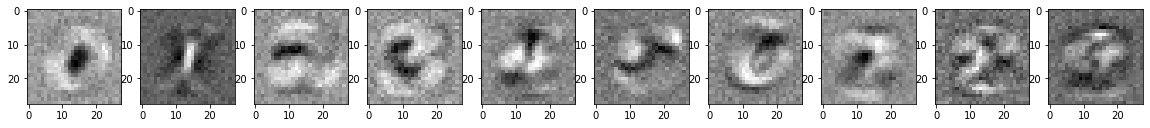

In [31]:
# Get weights
fig, ax = plt.subplots(1, 10, figsize=(20, 2))

for digit in range(10):
    ax[digit].imshow(W[:,digit].detach().view(28,28), cmap='gray')

The Full Code
The entire model, with the complete model definition, training, and evaluation (but minus the weights visualization) as independently runable code:

In [32]:
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

# Load the data
mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

## Training
# Initialize parameters
W = torch.randn(784, 10)/np.sqrt(784)
W.requires_grad_()
b = torch.zeros(10, requires_grad=True)

# Optimizer
optimizer = torch.optim.SGD([W,b], lr=0.1)

# Iterate through train set minibatchs 
for images, labels in tqdm(train_loader):
    # Zero out the gradients
    optimizer.zero_grad()
    
    # Forward pass
    x = images.view(-1, 28*28)
    y = torch.matmul(x, W) + b
    cross_entropy = F.cross_entropy(y, labels)
    # Backward pass
    cross_entropy.backward()
    optimizer.step()

## Testing
correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images.view(-1, 28*28)
        y = torch.matmul(x, W) + b
        
        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
    
print('Test accuracy: {}'.format(correct/total))


Test accuracy: 0.9027000069618225


Note: The accuracy from the full version directly above might return a slightly different test accuracy from the step-by-step version we first went through. We trained our model with stochastic gradient descent (SGD), with the word "stochastic" highlighting that training is an inherently random process.

Higher level APIs
So far, we've primarily been building neural networks with fairy basic PyTorch operations. We did this to provide a clearer picture of how models actually work and what's going on under the hood. This can be important as you're learning concepts and the various frameworks, and sometimes the low-level control is necessary if you're trying to build something novel.

However, most of the time, we do find ourselves repeating the same fairly standard lines of code, which can slow us down. Worse, it clutters up our code unnecessarily and introduces room for bugs and typos. And finally, as researchers or engineers, we would like to spend most of our time thinking on the highest levels of abstractions: I want to add a convolution layer here, then a fully-connected there, etc. Having to code all the small details are distractions that can detract from our ability to translate ideas into code. For this reason, PyTorch has higher level abstractions to help speed up implementation and improve model organization. While there are many ways to organize PyTorch code, one common paradigm is with torch.nn.Module.

Object-oriented Refactorization
It often makes sense for us to code our models in an object-oriented manner. To understand why, let's look back at the linear transformation 𝑦=𝑥𝑊+𝑏 that we used for logistic regression. We can see that while the operation consisted of a matrix multiplication and addition, also associated with this operation was the instantiation of two parameters W and b, and these two parameters conceptually belong to the transform. As such, it would make sense to bundle up the instantiation of the two parameters with the actual transformation:

In [33]:
# Note: illustrative example only; see below for torch.nn usage
class xW_plus_b:
    def __init__(self, dim_in, dim_out):
        self.W = torch.randn(dim_in, dim_out)/np.sqrt(dim_in)
        self.W.requires_grad_()
        self.b = torch.zeros(dim_out, requires_grad=True)
        
    def forward(self, x):
        return torch.matmul(x, self.W) + self.b

To use what we just wrote, we can create an xW_plus_b instance using its __init__() method (the constructor). In this case, we're going to set the dimensions to be 784 and 10, as we did in our logisitic regression example above. This creates an xW_plus_b instance with two parameters W and b.

In [34]:
# Note: illustrative example only; see below for torch.nn usage
lin_custom = xW_plus_b(784, 10)
print("W: {}".format(lin_custom.W.shape))
print("b: {}".format(lin_custom.b.shape))

W: torch.Size([784, 10])
b: torch.Size([10])


After instantiating the instance, we can perform the actual linear transform of our custom xW_plus_b class by calling the instance's forward() function:

In [35]:
# Note: illustrative example only; see below for torch.nn usage
x_rand = torch.randn(1,784)
y = lin_custom.forward(x_rand)
print(y.shape)

torch.Size([1, 10])


Using torch.nn
While we can certainly implement our own classes for the operations we'd like to use, we don't have to, as PyTorch already has them in the torch.nn sublibrary.

In [36]:
import torch.nn as nn

For example, the linear transform example we just went through is called torch.nn.Linear:

In [38]:
lin = nn.Linear(784, 10)
print("Linear parameters: {}".format([p.shape for p in lin.parameters()]))

y = lin(x_rand)
print(y.shape)

Linear parameters: [torch.Size([10, 784]), torch.Size([10])]
torch.Size([1, 10])


The implementation for nn.Linear has a few more things under the hood (notice for example that the forward() function is aliased with calling the instance itself), but in spirit, it operates in much the same way as our custom xW_plus_b class. In the first line, we instantiate a Linear object, which automatically creates weight and bias variables of the specified dimensions. The fourth line then calls the forward() function (aliased with the object call), which performs the linear transformation.

Using torch.nn.Module
The torch.nn.Linear class we just saw is a subclass of torch.nn.Module. However, Modules do not have to just describe a single operation; they can also define a chain of operations, each of which may also be Modules. As such, we can place our entire neural network within a Module. In this case, the module can track all of its associated parameters, some of which may also be associated with a submodule (e.g. nn.Linear), while also defining the forward() function, in one place.

In [39]:
class MNIST_Logistic_Regression(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, x):
        return self.lin(x)

In this particular example, we didn't need to chain any operations, but we'll see this come in handy as we move on to more complex models. Additionally, the nn.Module that we subclassed has a few other nice features. For example:

The forward() function of a nn.Module will call the forward() function of any child nn.Modules.
print() will print out a formatted summary of our model, recursively summarizing any child nn.Modules as well.
The parameters() function will return a generator that returns all parameters of a nn.Module (including those of any children).

In [40]:
model = MNIST_Logistic_Regression()
y = model(x_rand)
print("The model: \n{}".format(model))
print("\nParameters: \n{}".format(list(model.parameters())))
print("\nOutput shape: \n{}".format(y.shape))

The model: 
MNIST_Logistic_Regression(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

Parameters: 
[Parameter containing:
tensor([[ 0.0178, -0.0035, -0.0328,  ...,  0.0323,  0.0152, -0.0267],
        [ 0.0039, -0.0275, -0.0149,  ...,  0.0081, -0.0063,  0.0085],
        [-0.0317,  0.0242,  0.0296,  ..., -0.0124,  0.0123, -0.0281],
        ...,
        [-0.0080,  0.0064, -0.0282,  ...,  0.0144, -0.0172,  0.0219],
        [-0.0331, -0.0276,  0.0323,  ...,  0.0180, -0.0194, -0.0070],
        [-0.0256,  0.0187,  0.0030,  ...,  0.0150,  0.0090,  0.0086]],
       requires_grad=True), Parameter containing:
tensor([-0.0339, -0.0024,  0.0194, -0.0345, -0.0270,  0.0156, -0.0304, -0.0339,
        -0.0042, -0.0040], requires_grad=True)]

Output shape: 
torch.Size([1, 10])


Full code with nn.Module
Refactoring our previous complete logistic regression code to use a nn.Module:

In [41]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

class MNIST_Logistic_Regression(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, x):
        return self.lin(x)

# Load the data
mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

## Training
# Instantiate model
model = MNIST_Logistic_Regression()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Iterate through train set minibatchs 
for images, labels in tqdm(train_loader):
    # Zero out the gradients
    optimizer.zero_grad()
    
    # Forward pass
    x = images.view(-1, 28*28)
    y = model(x)
    loss = criterion(y, labels)
    # Backward pass
    loss.backward()
    optimizer.step()

## Testing
correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images.view(-1, 28*28)
        y = model(x)
        
        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
    
print('Test accuracy: {}'.format(correct/total))


Test accuracy: 0.9047999978065491


While the benefits of organizing a model as a nn.Module may not be as obvious for a simple logistic regression model, such a programming style allows for much quicker and cleaner implementations for more complex models, as we'll see in later notebooks.